In [2]:
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
from numpy import unique, where
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

import seaborn as sns
import numpy as np
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import make_scorer, adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn import preprocessing 
import plotly.express as px
import time

## Importing Datasets

In [3]:
datasets = {
    "Spherical Clusters": pd.read_csv('./Datasets/Speherical_Clusters.csv'),
    "Moon Clusters": pd.read_csv('./Datasets/moons_Clusters.csv'),
    "Nested Clusters": pd.read_csv('./Datasets/Nested_Clusters.csv'),
    "Hierarchical Structure": pd.read_csv('./Datasets/Mall_Customers.csv')
    
}
label_encoder = preprocessing.LabelEncoder() 

#encode gender
datasets['Hierarchical Structure']['Gender'] = label_encoder.fit_transform(datasets['Hierarchical Structure']['Gender'])

## Data Preprocessing Function

In [5]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop="if_binary", sparse_output=False)


def preprocess(
    dataset_name, return_original=False, return_scaler=False, return_encoder=False
):
    data = datasets[dataset_name]
    if dataset_name == "Hierarchical Structure":
        enc_gender = encoder.fit_transform(data[["Gender"]])
        scaled_numerical = scaler.fit_transform(
            data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]
        )
        X = np.hstack((enc_gender, scaled_numerical))
        y = None

    else:
        data = data.to_numpy()
        X = scaler.fit_transform(data[:, :-1])
        y = data[:, -1]

    result = [X, y]
    if return_original:
        result.append(data)

    return tuple(result)




## Function to plot clustering result

In [6]:
def plot_clustering_and_truth(X, y, model):
    """
    Plots the clustering results and the ground truth labels in separate graphs.

    Parameters:
    - X: The input data (features).
    - y: The ground truth labels.
    - model: The fitted Gaussian Mixture Model.

    Returns:
    - None
    """
    # Predict the cluster labels using the fitted model
    cluster_labels = model.predict(X)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot GMM clustering results
    axes[0].scatter(X[:, 0], X[:, 1], c=cluster_labels, s=30, cmap='viridis', alpha=0.6)
    axes[0].set_title('GMM Clustering Results')
    axes[0].set_xlabel('Feature 1')
    axes[0].set_ylabel('Feature 2')

    # Plot ground truth labels
    axes[1].scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='jet', alpha=0.6)
    axes[1].set_title('Ground Truth Labels')
    axes[1].set_xlabel('Feature 1')
    axes[1].set_ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

## Parameter Grid for Gaussian Mixture Model Optimization

In [37]:
params = {
    'n_components': [4],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'max_iter': [100, 200, 300], 
    'init_params': ['kmeans','random_from_data','k-means++', 'random'],  
    'tol': [1e-3 ,1e-4,1e-5,1e-6],  
}

## Evaluation Function

In [42]:
def evaluate_gmm_model(X, y=None, gmm_model=None, ground_truth=True):
    """
    Evaluates the Gaussian Mixture Model using various metrics.

    Parameters:
    X : array-like, shape (n_samples, n_features)
        The input data.
    y : array-like, shape (n_samples,), optional
        The ground truth labels. Default is None.
    gmm_model : GaussianMixture
        The trained GMM model.
    ground_truth : bool
        Whether to include ground truth evaluation metrics.

    Returns:
    metrics : dict
        A dictionary containing silhouette score, ARI (if ground_truth is True), and Davies-Bouldin index.
    """
    # Predict cluster labels
    labels = gmm_model.predict(X)

    # Calculate evaluation metrics
    silhouette_avg = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)

    metrics = {
        "Silhouette Score": silhouette_avg,
        "Davies-Bouldin Score": db_score
    }

    # Include ARI if ground truth is provided
    if ground_truth and y is not None:
        ari = adjusted_rand_score(y, labels)
        metrics["Adjusted Rand Index"] = ari

    return metrics

## GMM on Spherical Clusters

Best Parameters: {'covariance_type': 'tied', 'init_params': 'kmeans', 'max_iter': 100, 'n_components': 4, 'tol': 0.01}
Best BIC Score: -1.7424313607915518


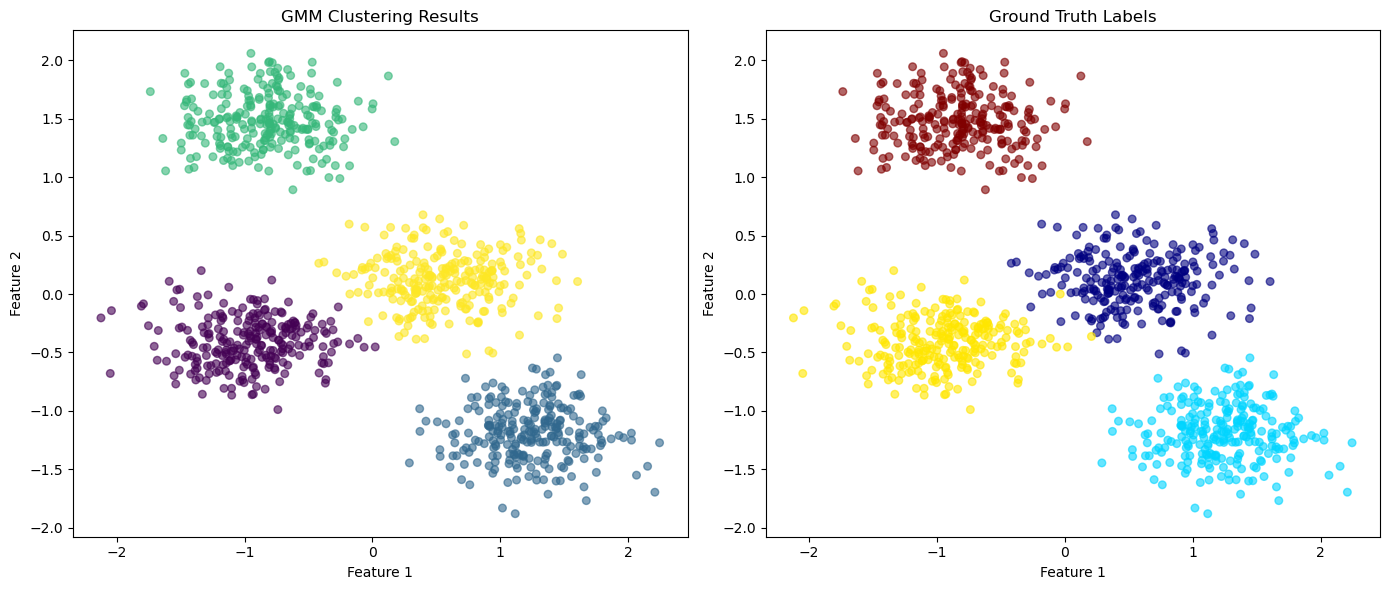

In [9]:
X, y = preprocess("Spherical Clusters")
gmm = GaussianMixture(random_state=0)
grid_search = GridSearchCV(estimator=gmm, param_grid=params, cv=5)
grid_search.fit(X)


print("Best Parameters:", grid_search.best_params_)
print("Best BIC Score:", grid_search.best_score_)

# Plot the clustering results
best_gmm_model = grid_search.best_estimator_
plot_clustering_and_truth(X, y, best_gmm_model)


### Performance Evaluation

In [11]:
# Evaluate the model
evaluation_metrics = evaluate_gmm_model(X, y, best_gmm_model)

# Print the evaluation metrics
for metric, score in evaluation_metrics.items():
    print(f"{metric}: {score:.4f}")

Silhouette Score: 0.6537
Adjusted Rand Index: 0.9920
Davies-Bouldin Score: 0.4701


## GMM on Moon Clusters

c:\Users\liang\anaconda3\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\liang\anaconda3\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\liang\anaconda3\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\liang\anaconda3\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'covariance_type': 'tied', 'init_params': 'kmeans', 'max_iter': 100, 'n_components': 2, 'tol': 1e-06}
Best BIC Score: -2.6041061566992556


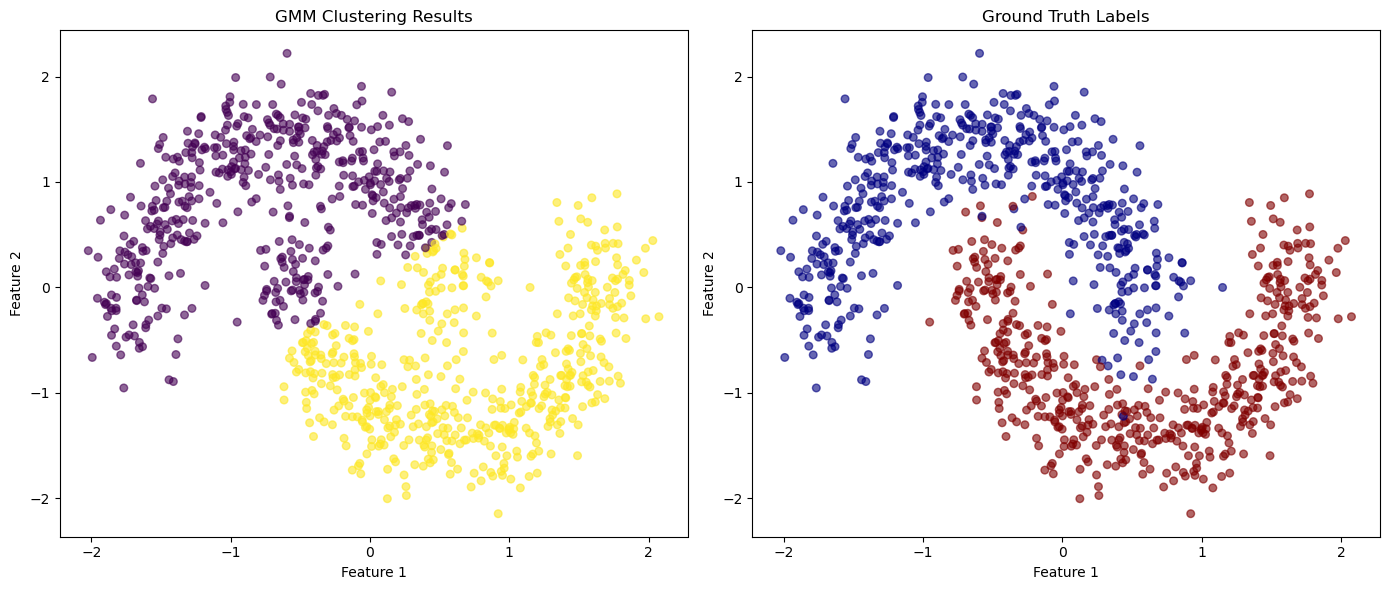

In [24]:
X, y = preprocess("Moon Clusters")
gmm = GaussianMixture(random_state=0)
grid_search = GridSearchCV(estimator=gmm, param_grid=params, cv=5)
grid_search.fit(X)


print("Best Parameters:", grid_search.best_params_)
print("Best BIC Score:", grid_search.best_score_)

# Plot the clustering results
best_gmm_model = grid_search.best_estimator_
plot_clustering_and_truth(X, y, best_gmm_model)

### Performance Evaluation

In [25]:
# Evaluate the model
evaluation_metrics = evaluate_gmm_model(X, y, best_gmm_model)

# Print the evaluation metrics
for metric, score in evaluation_metrics.items():
    print(f"{metric}: {score:.4f}")

Silhouette Score: 0.4805
Adjusted Rand Index: 0.5036
Davies-Bouldin Score: 0.8258


## GMM on Nested Clusters

c:\Users\liang\anaconda3\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\liang\anaconda3\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\liang\anaconda3\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\liang\anaconda3\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\lia

Best Parameters: {'covariance_type': 'diag', 'init_params': 'random_from_data', 'max_iter': 100, 'n_components': 3, 'tol': 0.001}
Best BIC Score: 2.4679128802463635


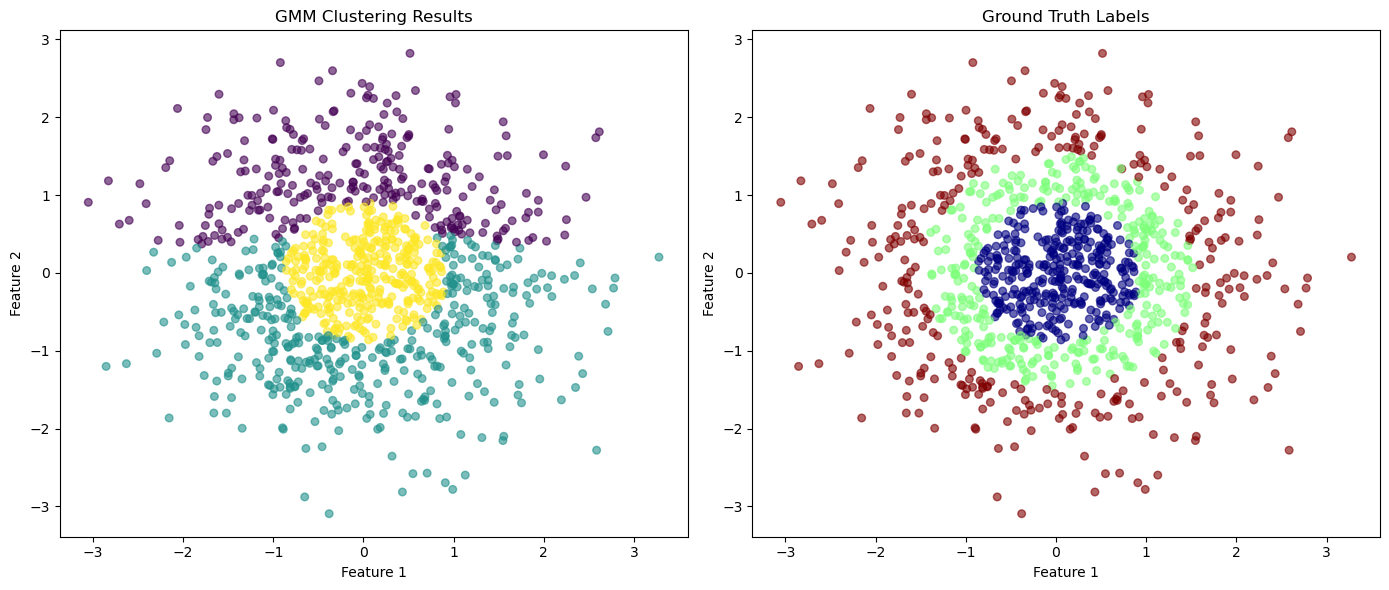

In [29]:
X, y = preprocess("Nested Clusters")
gmm = GaussianMixture(random_state=0)
grid_search = GridSearchCV(estimator=gmm, param_grid=params, cv=5)
grid_search.fit(X)


print("Best Parameters:", grid_search.best_params_)
print("Best BIC Score:", grid_search.best_score_)

# Plot the clustering results
best_gmm_model = grid_search.best_estimator_
plot_clustering_and_truth(X, y, best_gmm_model)

In [30]:
# Evaluate the model
evaluation_metrics = evaluate_gmm_model(X, y, best_gmm_model)

# Print the evaluation metrics
for metric, score in evaluation_metrics.items():
    print(f"{metric}: {score:.4f}")

Silhouette Score: 0.3479
Adjusted Rand Index: 0.5083
Davies-Bouldin Score: 1.2338


### GMM on Hierarchical Cluster

In [38]:
X, y = preprocess("Hierarchical Structure")
gmm = GaussianMixture(random_state=0)
grid_search = GridSearchCV(estimator=gmm, param_grid=params, cv=5)
grid_search.fit(X)


print("Best Parameters:", grid_search.best_params_)
print("Best BIC Score:", grid_search.best_score_)

# Plot the clustering results
best_gmm_model = grid_search.best_estimator_

# Predict clusters using the best model
gmm_result = best_gmm_model.predict(X)

# Create a DataFrame for visualization
df = pd.DataFrame(X, columns=['Gender_Male', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
df['GMM_Cluster'] = gmm_result

# Plot the 3D scatter plot
fig = px.scatter_3d(df, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)', color='GMM_Cluster',
                    title="3D GMM Clustering on Mall Customers Dataset", labels={'GMM_Cluster': 'Cluster'})
fig.update_traces(marker=dict(size=5)) 

fig.show()

c:\Users\liang\anaconda3\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\liang\anaconda3\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\liang\anaconda3\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\liang\anaconda3\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\lia

Best Parameters: {'covariance_type': 'diag', 'init_params': 'random_from_data', 'max_iter': 100, 'n_components': 4, 'tol': 0.001}
Best BIC Score: -2.6211202397153053


### Performance Evaluation

In [43]:
# Evaluate the model
evaluation_metrics = evaluate_gmm_model(X, y, best_gmm_model, False)

# Print the evaluation metrics
for metric, score in evaluation_metrics.items():
    print(f"{metric}: {score:.4f}")

Silhouette Score: 0.2970
Davies-Bouldin Score: 1.1052
